# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import os
#causes crash without this
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import gym
import random
import torch
import numpy as np
from collections import deque

from ddpg_agent import Agent

def showScores(scores):
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

#modified from pendulum activity
def ddpg(n_episodes=1000, max_t=300, print_every=100,
         fc1_units=400, fc2_units=300,
                replay_buffer_size=int(1e5), minibatch_size=128, gamma=0.99, tau=1e-3, 
                 actor_learning_rate=1e-4, critic_learning_rate=1e-3, weight_decay=0,
                mu_noise=0., theta_noise=0.15, sigma_noise=0.2, random_seed=2):
    
    agents = []
    for i in range(num_agents):
        agent = Agent(state_size, action_size, random_seed, fc1_units, fc2_units,
                replay_buffer_size, minibatch_size, gamma, tau, 
                 actor_learning_rate, critic_learning_rate, weight_decay,
                mu_noise, theta_noise, sigma_noise)
        agents.append(agent)
    
    scores_deque = deque(maxlen=print_every)
    scores = [0] * num_agents
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        
        for i in range(num_agents):
            state = states[i]
            agents[i].reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state)
                env_info=env.step(action)[brain_name]        # send action to the environment
                next_state = env_info.vector_observations[i]
                reward = env_info.rewards[i]
                done = env_info.local_done[i]
                agents[i].step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            scores[i] = score
            
        worst_training_agent_score = np.min(scores)
        scores_deque.append(worst_training_agent_score)
        average_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        
        
        if average_score > 30:
            print('Environment Solved!!!!\n')
            break
        elif i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            
    print("\n")
    return list(scores_deque)

Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=400 fc2_units=300
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.0001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.2
Using device: cuda:0
Episode 100	Average Score: 0.01


Default values:


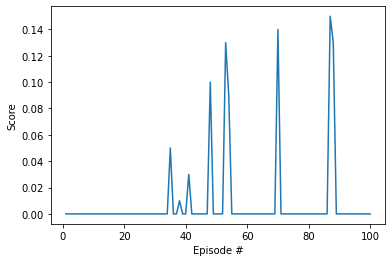

In [6]:
#default values check with 100 episodes
scores = ddpg(100)

print("Default values:")
showScores(scores)

Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=128 fc2_units=128
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.0001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.2
Using device: cuda:0
Episode 100	Average Score: 0.01


Change neural network node size for potential simplification:


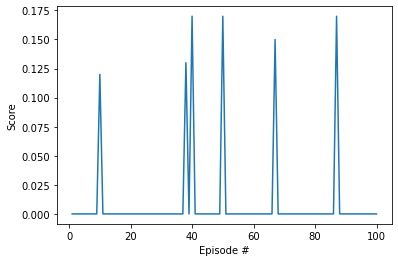

In [7]:
#Try using less nodes for faster learning
scores = ddpg(100, 300, 100, 128, 128)

print("Change neural network node size for potential simplification:")
showScores(scores)

Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=400 fc2_units=300
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.2
Using device: cuda:0
Episode 100	Average Score: 0.01


Increase actor learn rate:


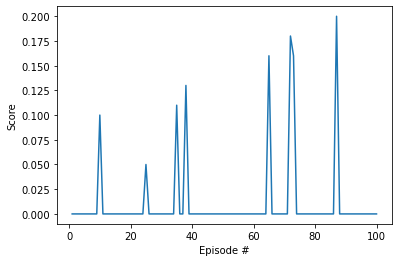

In [8]:
#Increase actor learning
scores = ddpg(100, 300, 100, 400, 300, int(1e5), 128, 0.99, 0.001, 0.001, 0.001)

print("Increase actor learn rate:")
showScores(scores)

Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=128 fc2_units=128
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.2
Using device: cuda:0
Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02


Increase actor learn rate and less NN nodes:


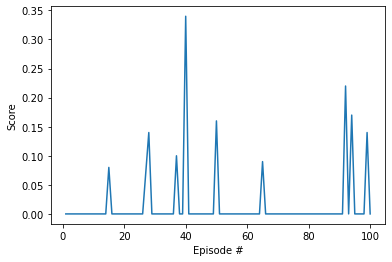

In [9]:
#Increase actor learning
scores = ddpg(200, 300, 100, 128, 128, int(1e5), 128, 0.99, 0.001, 0.001, 0.001)

print("Increase actor learn rate and less NN nodes:")
showScores(scores)

Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=128 fc2_units=128
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.1
Using device: cuda:0
Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.02


Increase actor learning, reduce nodes, reduce noise std:


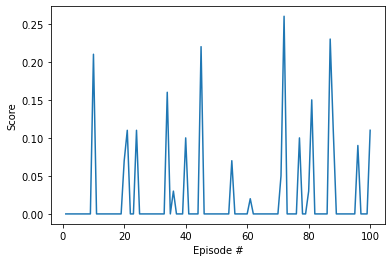

In [10]:
#Increase actor learning, reduce nodes, reduce noise std
scores = ddpg(200, 300, 100, 128, 128, int(1e5), 128, 0.99, 0.001, 0.001, 0.001, 0, 0., 0.15, 0.1)

print("Increase actor learning, reduce nodes, reduce noise std:")
showScores(scores)

In [ ]:
#Increase actor learning, reduce nodes, reduce noise std
scores = ddpg(1000, 300, 100, 128, 128, int(1e5), 128, 0.99, 0.001, 0.001, 0.001, 0, 0., 0.15, 0.1)

print("Final Model: Increase actor learning, reduce nodes, reduce noise std seems to be the best:")
showScores(scores)

### 4. Watch a Smart Agent!

In [14]:
env_info = env.reset(train_mode=False)[brain_name] 

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

agents = []
for i in range(num_agents):
    agent = Agent(state_size, action_size, 2, 128, 128, 
                  int(1e5), 128, 0.99, 0.001, 0.001, 0.001, 0, 0., 0.15, 0.1)
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
    agents.append(agent)

        
for i in range(num_agents):
    state = states[i]
    agents[i].reset()
    score = 0
    for t in range(300):
        action = agent.act(state, add_noise=False)
        env_info=env.step(action)[brain_name]        # send action to the environment
        next_state = env_info.vector_observations[i]
        reward = env_info.rewards[i]
        done = env_info.local_done[i]
        agents[i].step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
print(f"Score: {score}")
env.close()

Number of agents: 1
Size of each action: 4
Agent parameters: state_size=33 action_size=4 random_seed=2
               fc1_units=128 fc2_units=128
               replay_buffer_size=100000 minibatch_size=128 gamma=0.99
               tau=0.001 actor_learning_rate=0.001 critic_learning_rate=0.001
               l2_weight_decay=0
               mu_noise=0.0 theta_noise=0.15 sigma_noise=0.1
Using device: cuda:0
Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```